 # todos



 ## general todos

[ ] eventually fix the paths for anyone not running this from src directory (remove ...)

[x] map setup numbers to better names for all plots

[ ] traverse setup folders and concat dfs

[ ] do some significance tests based on results_df

[ ] combine ALL the run results and do a regression with a lot more parameters!

 ## Plots I want this to work on

[ ] Time plot?

[x] Fitness_plot

    [ ] comparing best vs. avg vs best species (needs to be only done once)

[x] Total components?

[x] Unique components per generation

[x] Mutation boxplot effects

[x] fitness Metrics plots



[ ] best genome mutation analysis

[x] Mutation lineplots

[x] Average metrics?

[ ] Number species

[x] Spawn rank histogram

[x] Scatterplot

 ## Do not forget about single-run plots, they should also be in here

[ ] best genome lineage

[ ] species leaders??

[ ] species stackplot

[ ] species tree

[ ] species ridgeline

[ ] species average fitnesses

[ ] fitness scatterplot (as implemented in look_at_dfs) - can only do that for one run

 ## Other analysis implemented someplace else

[ ] ... check the onenote

 ## Interesting one-off analysis

[ ] Mutation lineage for a selected run

[ ] Component similarity drift

[ ] Fitness of components plotting

    - Look at the components in the fittest genome at the end, plot their t-values obtained from the component dict over the generations

 ## Those can only be copied from a run

[ ] improvements (combine them into something)

[ ] species leaders??

# Analysis of results
In this notebook, I will track all the plots used in the Thesis.

The first step will be evaluating individual selection strategies, with the goal of determining appropriate parameter settings for each selection strategy before comparing the selection strategies agains one another.

For those initial comparisons, I will be sticking to the `running_example.xes` log, but bigger logs will be compared.

## Selection strategy - truncation
First off, analyzing the truncation selection strategy

The Data is from a run with the following parameter permutations
* `spawn_cutoff`: 0.1, 0.25, 0.5, 0.75
* `pop_perc_elite`: 0.01, 0.05
* `pop_perc_crossover`: 0.0, 0.1, 0.2, 0.3, 0.4

### Regression on truncation parameters
Probably the most influental parameter, it should directly expose the trade-offs of diversity vs. focus during the search. I.e. trading faster convergence for a narrower search. `spawn_cutoff` determines which portion of the population will be moved into the next.

For every parameter change, all the other parameter changes are also tested, resulting in a total of `4*2*5 = 40` setups. That also means that The spawn cutoff was tested with all `pop_perc_elite` and `pop_perc_crossover` settings. Each setup was run 20 times.

I did not run a test with 0% elitism, as elitism is crucial to the algorithms function. If there are no elite spawns, the best genome is not preserved, due to all asex spawns receiving mutations.

To investigate the hypothesis that spawn cutoff has the largest effect on achieved diversity, I rely on the num_components metric which was calculated for every run, as well as the highest achieved fitness and do a regression for both of those target variables. Predictors are the params that were changed, i.e. spawn cutoff, % elite spawns and % crossover spawns.

In [1]:
from importlib import reload # TODO: remove this later
import scripts.helper_scripts.setup_analysis as sa # helper module for fetching setup analysis
# crawl the results data and load it into a dict
res = sa.exec_results_crawler("../analysis/data/testing_truncation")

Processing setup directories: 13it [00:00, 129.03it/s]


Found cached results for setup_1
Successfully loaded cached results for setup_1

Found cached results for setup_10
Successfully loaded cached results for setup_10

Found cached results for setup_11
Successfully loaded cached results for setup_11

Found cached results for setup_12
Successfully loaded cached results for setup_12

Found cached results for setup_13
Successfully loaded cached results for setup_13

Found cached results for setup_14
Successfully loaded cached results for setup_14

Found cached results for setup_15
Successfully loaded cached results for setup_15

Found cached results for setup_16
Successfully loaded cached results for setup_16

Found cached results for setup_17
Successfully loaded cached results for setup_17

Found cached results for setup_18
Successfully loaded cached results for setup_18

Found cached results for setup_19
Successfully loaded cached results for setup_19

Found cached results for setup_2
Successfully loaded cached results for setup_2

Found c

Processing setup directories: 43it [00:00, 110.17it/s]

Successfully loaded cached results for setup_29

Found cached results for setup_3
Successfully loaded cached results for setup_3

Found cached results for setup_30
Successfully loaded cached results for setup_30

Found cached results for setup_31
Successfully loaded cached results for setup_31

Found cached results for setup_32
Successfully loaded cached results for setup_32

Found cached results for setup_33
Successfully loaded cached results for setup_33

Found cached results for setup_34
Successfully loaded cached results for setup_34

Found cached results for setup_35
Successfully loaded cached results for setup_35

Found cached results for setup_36
Successfully loaded cached results for setup_36

Found cached results for setup_37
Successfully loaded cached results for setup_37

Found cached results for setup_38
Successfully loaded cached results for setup_38

Found cached results for setup_39
Successfully loaded cached results for setup_39

Found cached results for setup_4
Success

In [2]:
regression_result = sa.run_regression(res, ["spawn_cutoff", "pop_perc_elite", "pop_perc_crossover"]);


Regression Results for num_components
--------------------------------------------------
R-squared: 0.9256
Adjusted R-squared: 0.9253

Standardized Coefficients:
spawn_cutoff          1185.5417 (p=0.0000)
pop_perc_elite        -223.6617 (p=0.0000)
pop_perc_crossover      49.7385 (p=0.0001)

Regression Results for max_fitness
--------------------------------------------------
R-squared: 0.0104
Adjusted R-squared: 0.0067

Standardized Coefficients:
spawn_cutoff             0.0070 (p=0.0157)
pop_perc_elite          -0.0038 (p=0.1884)
pop_perc_crossover      -0.0023 (p=0.4211)


Turns out that 92% of the variance in num_components can be explained by the selected parameters. All three predictors have significant effects on the number of components, with the largest effect being the positive effect of increasing the cutoff. Increasing the number of elite spawns, which are simply cloning the best genome without mutations (with the goal to increase the fraction of elite genomes in the spawnpool so they will mutate in the next generation) leads as expected to a decrease in diversity. And while the tested parameter differences for the crossover percentage are much larger than those for elite spawns (0.1-0.4 vs. just 0.05 to 0.1), crossover has the smallest effect on diversity in truncation selection. 

My current hypothesis why the effect of crossover on diversity is so small in absolute value is because the effect of crossover is dependent on the cutoff setting. This can be seen in [these graphs](analysis.ipynb#interaction-cutoff--crossover-on-absolute-fitness-and-number-of-components-at-the-end-of-run). With a higher cutoff, the positive effect of moderate crossover values (20-30%) is positive on the number of components. **TODO ADD OTHER LINK AS WELL TO THAT SECTION WHERE I DISCUSS RESULTS OF LINEPLOTS**


On the other hand, the effects of the tested parameters are pretty minimal on the achieved maximum fitness, with none being significant. This is because for this small log there is almost no correlation between diversity and max fitness achieved - as will be seen later in **TODO**: DO A SCATTER OF ALL THE RUNS AND CALC COMPONENT ~ FITNESS CORR. + test log size increases maybe change in the relation of diversity x fitness

When it comes to the highest achievable fitness, there are bigger knobs to turn - other selection strategies, mutation rates and the fitness function itself.

### Interaction cutoff ~ elitism on absolute fitness and number of components at the end of run
The barcharts below plot the average max fitness of each run, along with the avg. num of components that were discovered, when filtering for runs with both elitism and all 4 cutoff settings. The different crossover settings that were used for each of those parameter configurations are averaged out, i.e. each one of those bars includes data from all 5 crossover settings.

ValueError: Data source 'cutoff 10% & elite 5%' not found in data_sources

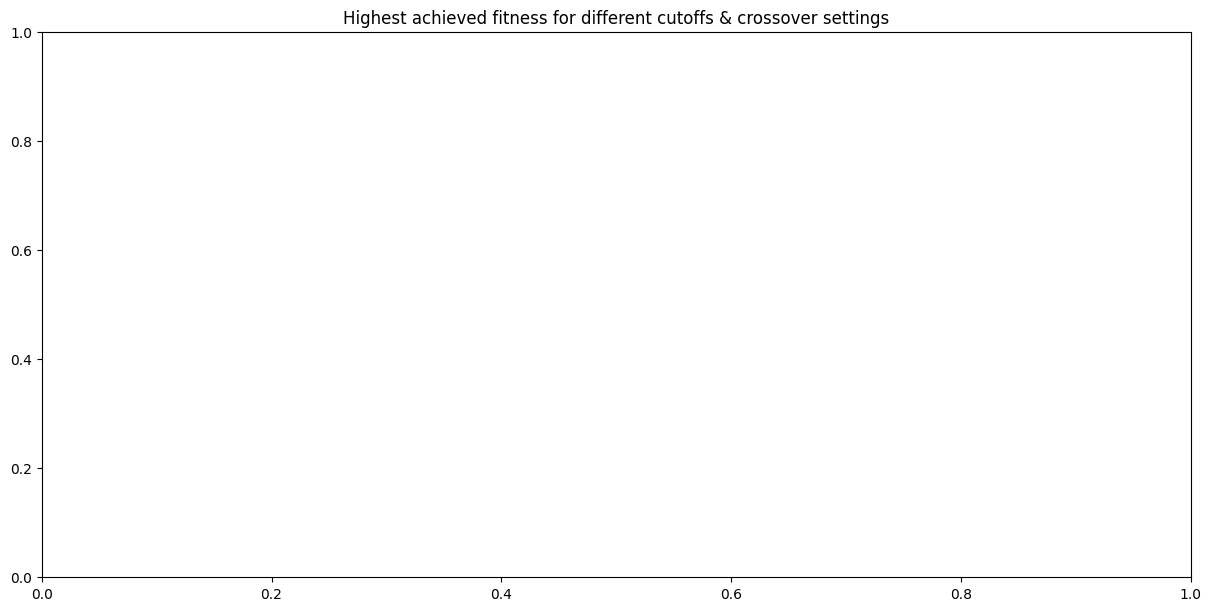

In [3]:
reload(sa)
# TODO: update text above

cutoff_elite_search = {
    "cutoff 10% & elite 5%": {"spawn_cutoff": 0.1, "pop_perc_elite": 0.05}, "cutoff 10% & elite 10%": {"spawn_cutoff": 0.1, "pop_perc_elite": 0.1},
    "cutoff 25% & elite 5%": {"spawn_cutoff": 0.25, "pop_perc_elite": 0.05}, "cutoff 25% & elite 10%": {"spawn_cutoff": 0.25, "pop_perc_elite": 0.1},
    "cutoff 50% & elite 5%": {"spawn_cutoff": 0.50, "pop_perc_elite": 0.05}, "cutoff 50% & elite 10%": {"spawn_cutoff": 0.50, "pop_perc_elite": 0.1},
    "cutoff 75% & elite 5%": {"spawn_cutoff": 0.75, "pop_perc_elite": 0.05}, "cutoff 75% & elite 10%": {"spawn_cutoff": 0.75, "pop_perc_elite": 0.1}
}


elite_plt_layout = [
    ["cutoff 10% & elite 5%", "cutoff 10% & elite 10%"],
    ["cutoff 25% & elite 5%", "cutoff 25% & elite 10%"],
    ["cutoff 50% & elite 5%", "cutoff 50% & elite 10%"],
    ["cutoff 75% & elite 5%", "cutoff 75% & elite 10%"]
]

elite_data_sources = sa.search_and_aggregate_param_results(res, cutoff_elite_search)
strip_first_param = lambda l: l.split('&')[1].strip().split('\n')[0] # lambda to be applied on labels
_ = sa.generalized_barplot(elite_plt_layout, elite_data_sources, "best_genome_fitness", title="Highest achieved fitness for different cutoffs & crossover settings", group_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"], label_lambda=strip_first_param)
_ = sa.generalized_barplot(elite_plt_layout, elite_data_sources, "num_total_components", title="Components discovered for different cutoffs & crossover settings", group_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"], label_lambda=strip_first_param)

This again shows how none of the settings really have an impact on the achieved mean fitness. At the end, I will compare all setups, i.e. all parameter permutations to identify the best settings within my sample and compare that to the analysis here. However elitism clearly exhibits a negative effect on the total number of components

### Interaction cutoff ~ crossover on absolute fitness and number of components at the end of run
I will now do the same visualization, this time filtering by cutoff and crossover rate, and both elitism settings will be averaged out.

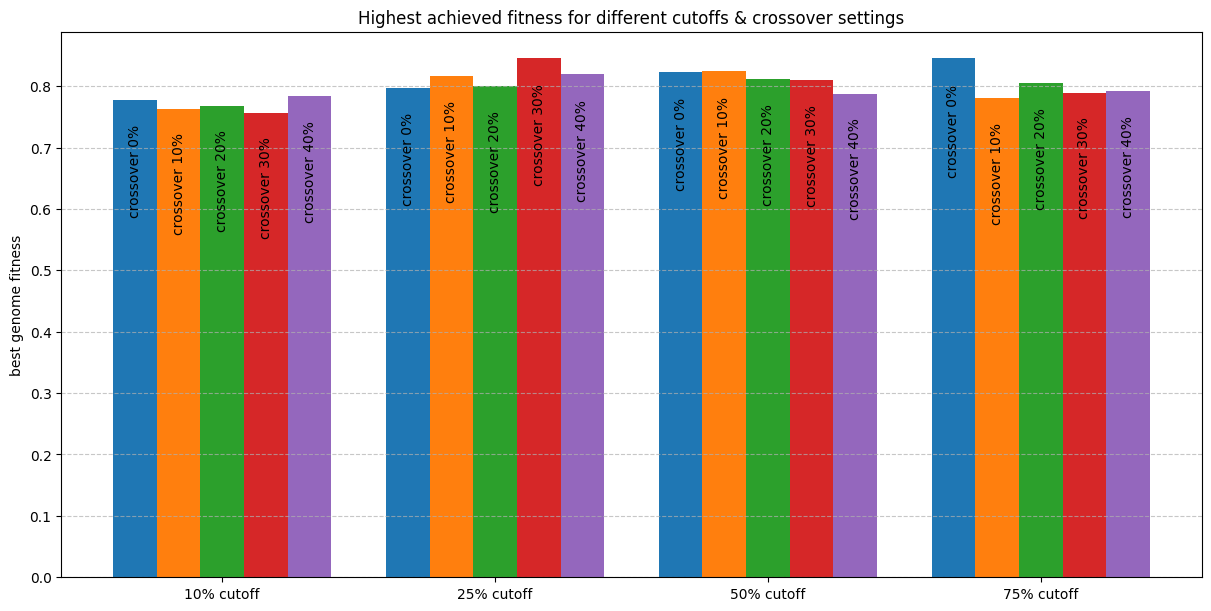

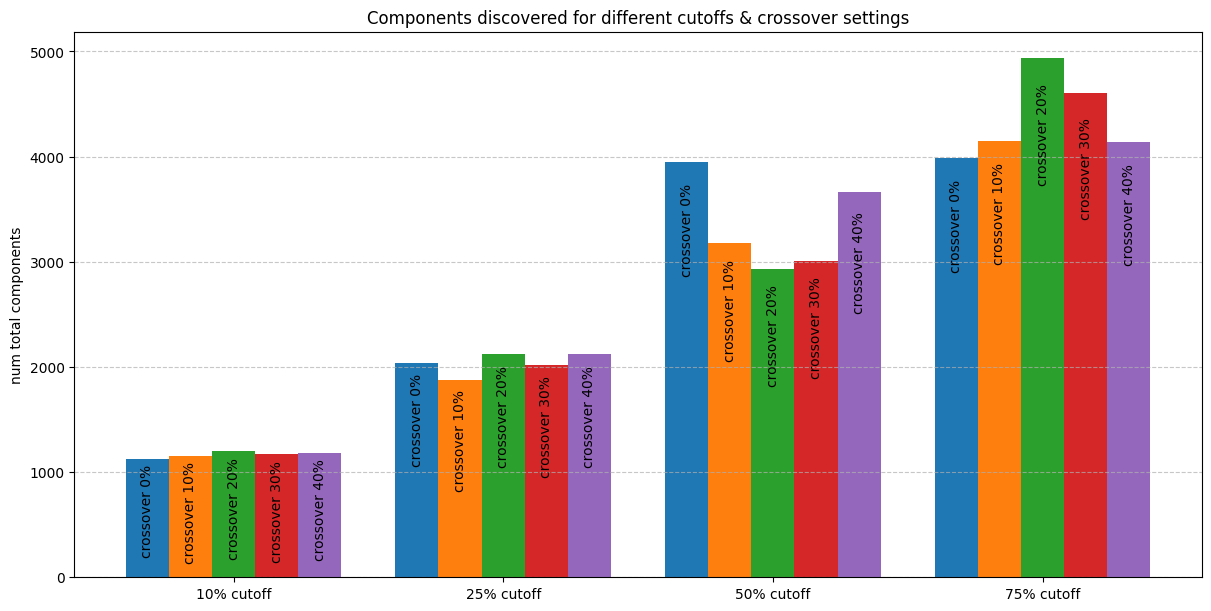

In [7]:
reload(sa)
cutoff_crossover_search = {
    "cutoff 10% & crossover 0%": {"spawn_cutoff": 0.10, "pop_perc_crossover": 0.0}, "cutoff 10% & crossover 10%": {"spawn_cutoff": 0.10, "pop_perc_crossover": 0.1}, "cutoff 10% & crossover 20%": {"spawn_cutoff": 0.10, "pop_perc_crossover": 0.2}, "cutoff 10% & crossover 30%": {"spawn_cutoff": 0.10, "pop_perc_crossover": 0.3}, "cutoff 10% & crossover 40%": {"spawn_cutoff": 0.10, "pop_perc_crossover": 0.4},
    "cutoff 25% & crossover 0%": {"spawn_cutoff": 0.25, "pop_perc_crossover": 0.0}, "cutoff 25% & crossover 10%": {"spawn_cutoff": 0.25, "pop_perc_crossover": 0.1}, "cutoff 25% & crossover 20%": {"spawn_cutoff": 0.25, "pop_perc_crossover": 0.2}, "cutoff 25% & crossover 30%": {"spawn_cutoff": 0.25, "pop_perc_crossover": 0.3}, "cutoff 25% & crossover 40%": {"spawn_cutoff": 0.25, "pop_perc_crossover": 0.4},
    "cutoff 50% & crossover 0%": {"spawn_cutoff": 0.50, "pop_perc_crossover": 0.0}, "cutoff 50% & crossover 10%": {"spawn_cutoff": 0.50, "pop_perc_crossover": 0.1}, "cutoff 50% & crossover 20%": {"spawn_cutoff": 0.50, "pop_perc_crossover": 0.2}, "cutoff 50% & crossover 30%": {"spawn_cutoff": 0.50, "pop_perc_crossover": 0.3}, "cutoff 50% & crossover 40%": {"spawn_cutoff": 0.50, "pop_perc_crossover": 0.4},
    "cutoff 75% & crossover 0%": {"spawn_cutoff": 0.75, "pop_perc_crossover": 0.0}, "cutoff 75% & crossover 10%": {"spawn_cutoff": 0.75, "pop_perc_crossover": 0.1}, "cutoff 75% & crossover 20%": {"spawn_cutoff": 0.75, "pop_perc_crossover": 0.2}, "cutoff 75% & crossover 30%": {"spawn_cutoff": 0.75, "pop_perc_crossover": 0.3}, "cutoff 75% & crossover 40%": {"spawn_cutoff": 0.75, "pop_perc_crossover": 0.4},
}

crossover_plt_layout = [
    ["cutoff 10% & crossover 0%", "cutoff 10% & crossover 10%", "cutoff 10% & crossover 20%", "cutoff 10% & crossover 30%", "cutoff 10% & crossover 40%"],
    ["cutoff 25% & crossover 0%", "cutoff 25% & crossover 10%", "cutoff 25% & crossover 20%", "cutoff 25% & crossover 30%", "cutoff 25% & crossover 40%"],
    ["cutoff 50% & crossover 0%", "cutoff 50% & crossover 10%", "cutoff 50% & crossover 20%", "cutoff 50% & crossover 30%", "cutoff 50% & crossover 40%"],
    ["cutoff 75% & crossover 0%", "cutoff 75% & crossover 10%", "cutoff 75% & crossover 20%", "cutoff 75% & crossover 30%", "cutoff 75% & crossover 40%"]
]


crossover_data_sources = sa.search_and_aggregate_param_results(res, cutoff_crossover_search)
strip_first_param = lambda l: l.split('&')[1].strip().split('\n')[0] # lambda to be applied on labels
_ = sa.generalized_barplot(crossover_plt_layout, crossover_data_sources, "best_genome_fitness", title="Highest achieved fitness for different cutoffs & crossover settings", group_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"], label_lambda=strip_first_param)
_ = sa.generalized_barplot(crossover_plt_layout, crossover_data_sources, "num_total_components", title="Components discovered for different cutoffs & crossover settings", group_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"], label_lambda=strip_first_param)

As already indicated by the linear regression, neither cutoff rate, nor crossover or elitism have a big impact on fitness. The situation with the number of discovered components is different though. Here Cutoff has the biggest effect, but interestingly both a high and a low crossover rate have different impacts depending on the cutoff. For a 50% cutoff, 0% and 40% (the two extreme settings) lead to more components, while at 75% cutoff the situation reverse and modest crossover rates of 20% & 30% have a positive effect on the number of components. I.e. it seems that the crossover effect is dependendent on the cutoff rate.

### Cutoff ~ Crossover - diversity & convergence
In the next step, I want to analyze how truncation selection convergences towards it's optimum in the different parameter settings.
First, let's look at the interaction between cutoff and crossover when converging on the final set of components, which should beespecially interesting based on the previous barplot.
For this, I will plot the number of components discovered in each generation on average to see how quickly the search widens.
Then I will plot the number of unique components, as selection pressure discards most components that are not useful.
Lastly, I will plot the fitness it achieves along the way.

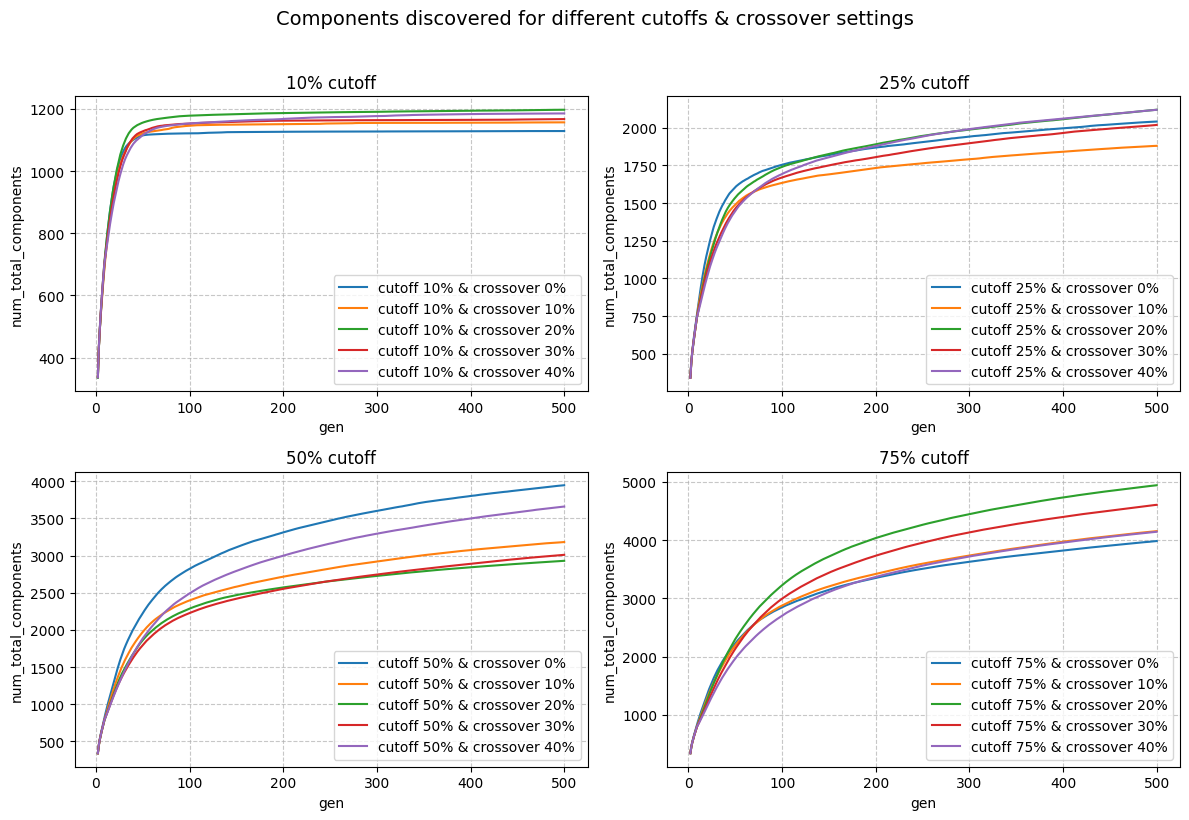

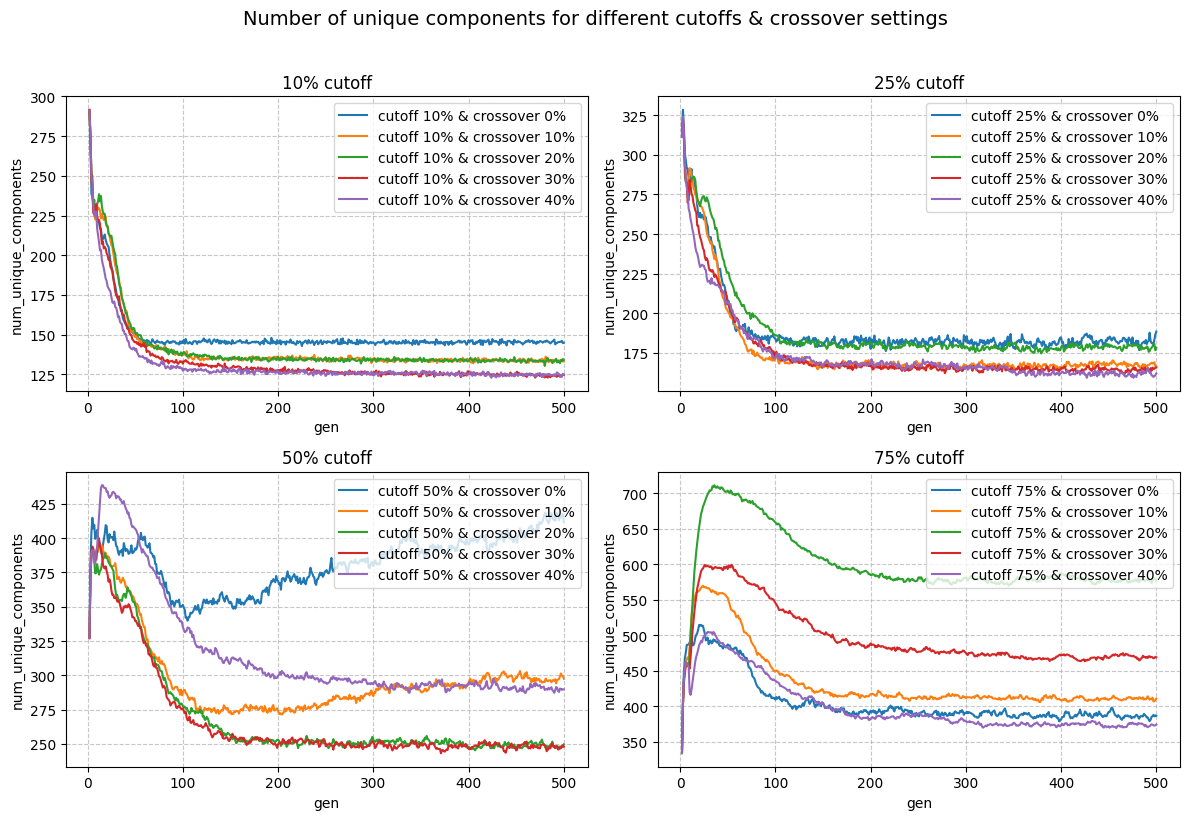

In [5]:
from copy import deepcopy
reload(sa)

# crossover components
_ = sa.generalized_lineplot(crossover_plt_layout, crossover_data_sources, "num_total_components", title="Components discovered for different cutoffs & crossover settings", subplt_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"])
_ = sa.generalized_lineplot(crossover_plt_layout, crossover_data_sources, "num_unique_components", title="Number of unique components for different cutoffs & crossover settings", subplt_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"], legend_loc="upper right")


**Observations:**

* **TODO**: the max num of components would be interesting here

**Calculating the total number of possible components:**
I think the total number of possible components can be calculated by considering all the connection that a place may have to transitions (not considering nets with hidden transitions here). For each transition there are three possibilities when connecting to a place:
* no connection
* outgoing
* incoming
The algorithm prevents symmetric connections between places and transitions, thus the number of possible connections and thus also components should be:

$3^{\sum transitions} = 3^{8} = 6561$ 

The setups with >= 50% cutoffs thus reach about half the search space with a population size of 500 within 500 generations, i.e. 250.000 models (though a lot of them share components or are elite spawns). This shows that the selection pressure does indeed work to stop the algorithm from just testing every random connection.

**unique components**
* **TODO**: try to find an explanation for weird crossover effects

* Independent of the chosen cutoff setting, all graphs show that there are roughly ~275 to ~325 components in the first generation. All graphs generally decrease in the number of unique components and then plateau (one exception: 0% crossover, 50% cutoff). The difference is how long it takes until this stagnation starts
    * With a low spawn cutoff (10% & 25%), the diversity starts to decrease pretty much at the start.
    * With a higher cutoff (50% & 75%), the diversity continues to rise for longer. and there are more unique components both at the peak and also towards the end of the run.
    * I think the decline in unique componenets starts as soon as the population starts to improve. Because it takes much longer to filter for good genomes with a high cutoff, the selection pressure on components is lower for a longer amount of time. That it takes longer to improve in fitness with a high cutoff is self-evident, but it can also be seen in the next graphs which plot fitness.

* I think crossover overall has a negative effect on diversity in the long run, because this can be seen in (quad 3, blue line)- without crossover, the number of unique components continues to rise, even after the "optimum" is reached in gen ~100
    * this would also make sense, since crossover effectively replaces the component of genome with that of another genome. Leading to one fewer component in the gene pool.
    * For all the tested parameters, crossover starts after 10 generations, and has the initial effect of decreasing the diversity, after which it quickly rebounds. This spike can be seen best on the 40% crossover line at 75% truncation (4th. Quadrant, purple line).

* This is however not true in every condition: When there is a really high cutoff, as in quad 4, there is both a higher sustained plateau level as well as a higher peak diversity when using just moderate amounts of crossover.
    * also, how can crossover have a negative impact, if in quad 3 the highest peak diversity is achieved by using crossover?
    * In the 75% cutoff both extreme values 10% and 40% crossover trend similarly towards a lower number of unique components, with the 20% crossover rate conserving the highest number of different components.
* It should be noted that the crossover function does select from the entire population. All these setups use a tournament size of 10, meaning 10 random genomes will be drawn from the entire population and the two fittest ones will be selected for mating (**TODO** test different tournament sizes). This should imply that there is a benefit of crossover for low cutoffs - but I'm not seeing that... And how does it explain moderate crossover being beneficial for high cutoffs??
    * It could also be exactly backwards - as indicated above, crossover does exert selection pressure. The bigger the tournament size, the higher the probability is that high-fitness individuals are chosen. What if high fitness corresponds to _more components per genome_? By preserving a moderate proportion of high fitness genomes, more components are preserved than when discarding those.
    * Another hypothesis could be that it is simply the influence of the modulo operator. I.e. When a high cutoff is chosen, and a certain percentage is crossover spawns, the loop does not get so far in the spawn and thus only so many genomes are selected!
        * I.e. for a high cutoff & high crossover - not as many genomes from the cutoff get to spawn, because already 40% (+5-10% of elites) of the spawns are allocated to crossover, leaving a smaller proportion of cutoff to be spawned. How does this explain high cutoff and low crossover generating fewer components overall though?
* What explains the rise of the green line from quad 3 to 4???
* While it seems that the graph in quadrant 4 contradicts this, with a moderate crossover rate

* Effect of different crossover rates is limited when a low cutoff is used. Probably because the search is already really focused and trends towards a very small number of components such that the crossover settings don't make much of a difference.

**num components**
* Here the effect of the cutoff parameter can be seeen dramatically. As indicated in the regression, a low cutoff leads to much fewer components. However only a really low cutoff of 10% leads to an early plateau, all other cutoff levels continue to grow the number of components discovered, albeit more slowly for the lower cutoffs.
* Again, it is the moderate crossover levels that lead to the most components discovered overall when using 75% cutoff, while at 50% cutoff the extreme values (0% & 40%) crossover produce more components.

### Cutoff ~ Crossover - fitness plot
The next plots show the fitness improvements in each generation, based on the selected cutoff and crossover parameters, again aggregating and averaging the elitism settings.


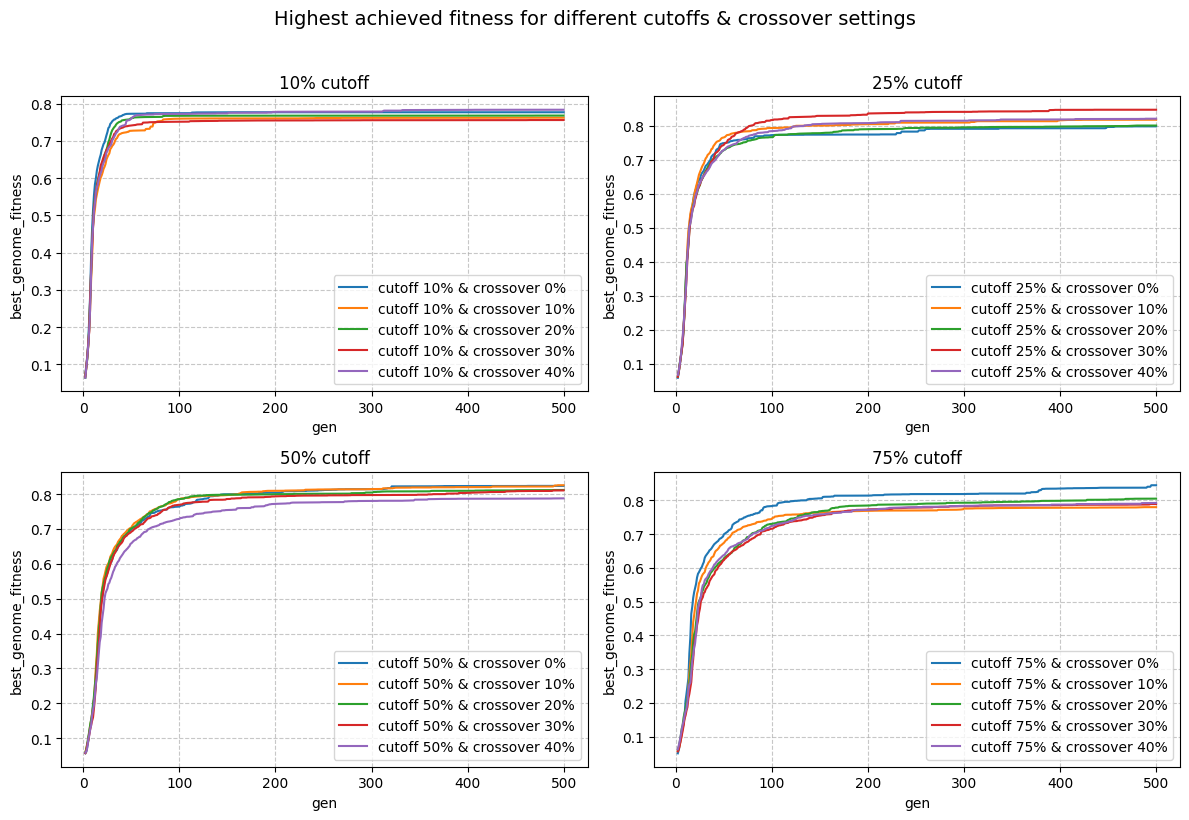

In [6]:
_ = sa.generalized_lineplot(crossover_plt_layout, crossover_data_sources, "best_genome_fitness", title="Highest achieved fitness for different cutoffs & crossover settings", subplt_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"])

In all of the selection strategy test setups, a fitness function was used that also considers the `num_arcs` metric, where a perfect score of 1.0 is not sensible to achieve - thus the overall fitness cannot reach 1.0.

Even though fitness seems to plateau on these graphs after ~100 gens, there is often a long tail of optimizations that should not be discarded - even though it is barely visible in these zoomed-out graphs. Examples of such improvements include removing one superfluous arc, leading to a slightly better `num_arcs` score.

While there is not much of a difference between the fitness plots, the 75% cutoff (4. Quadrant) is very interesting.
In contrast to the diversity metrics discussed above, a high cutoff and low crossover mix much better this time. I.e. while it is beneficial for diversity to have a high cutoff and some crossover, the same cannot be said about fitness. At 75% cutoff, the fitness score does take longer to incrase, but the best fitness curve can be seen when using no crossover combined with a high cutoff.

The benefit of crossover to fitness will be later investigated in more detail in the section on mutations (**TODO**: add a reference to this section here).

### Cutoff ~ elitism - diversity, convergence & fitness
After investigating the relation of crossover and cutoff, lets do the same for elitism.

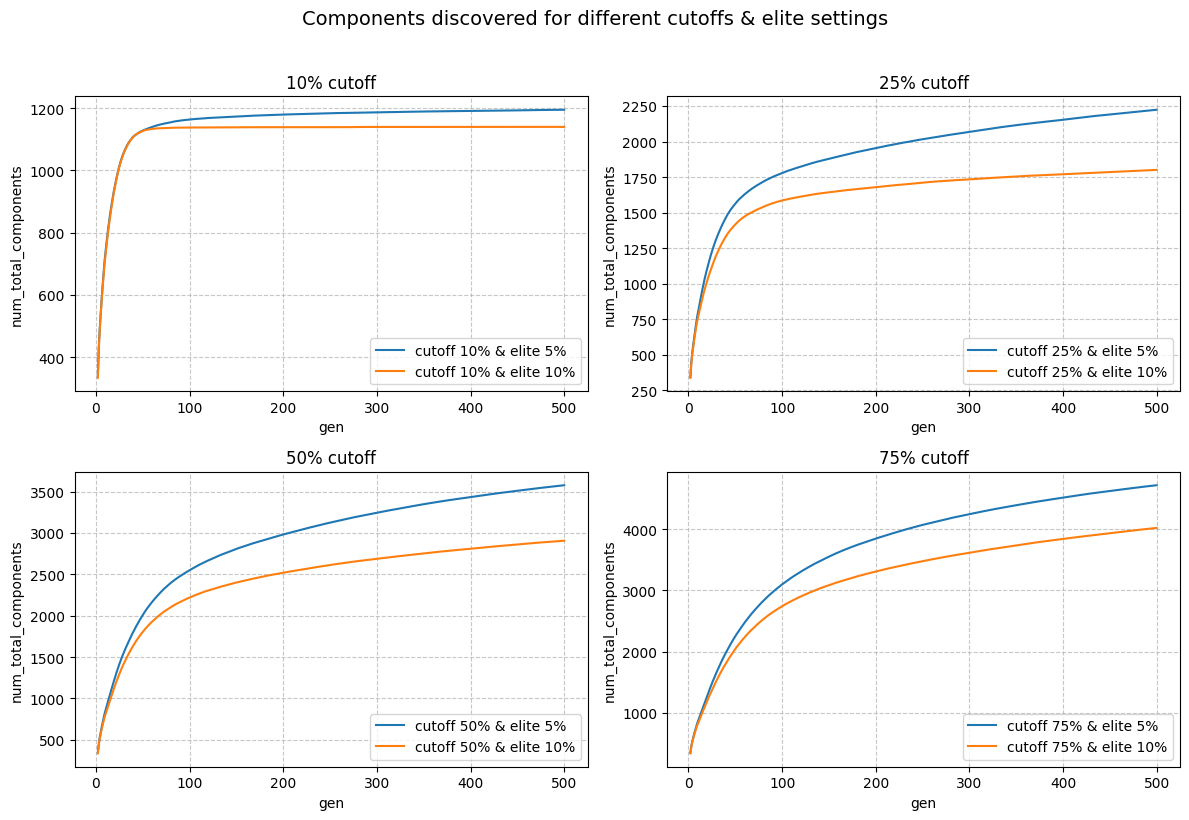

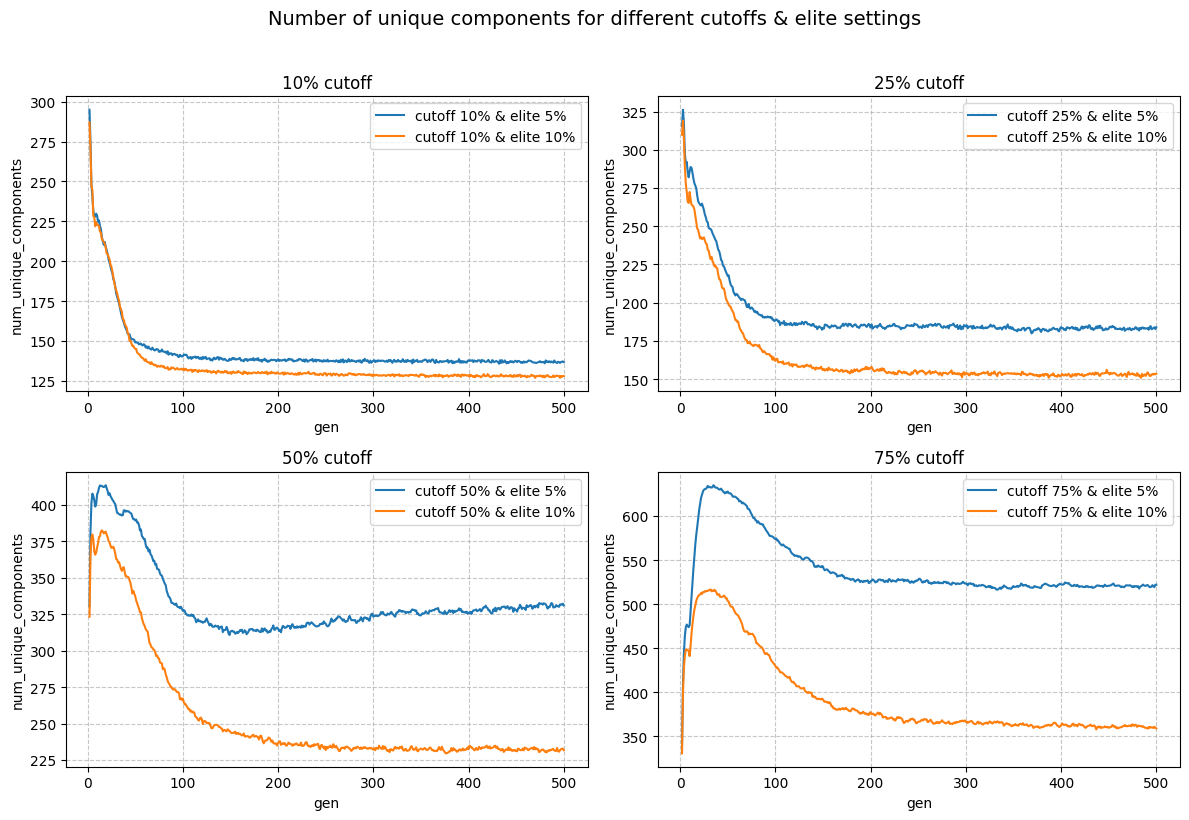

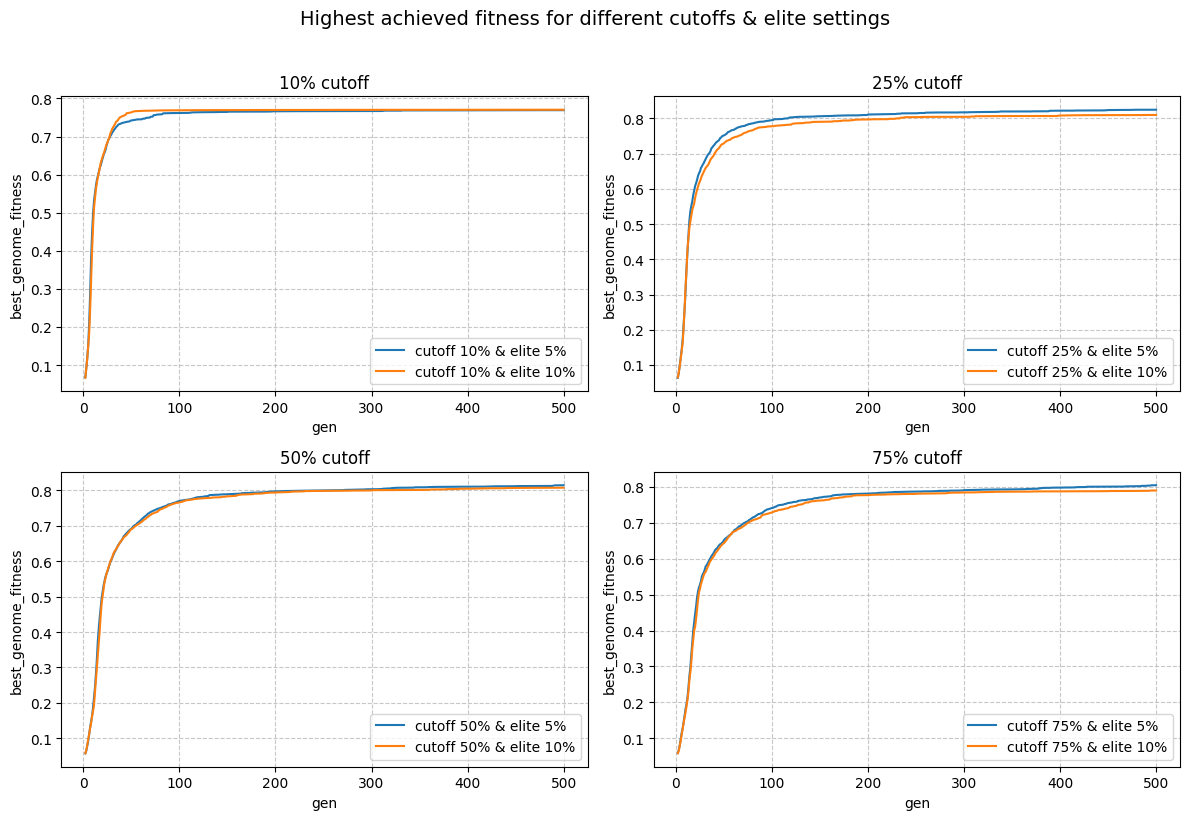

In [7]:
_ = sa.generalized_lineplot(elite_plt_layout, elite_data_sources, "num_total_components", title="Components discovered for different cutoffs & elite settings", subplt_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"])
_ = sa.generalized_lineplot(elite_plt_layout, elite_data_sources, "num_unique_components", title="Number of unique components for different cutoffs & elite settings", subplt_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"], legend_loc="upper right")
_ = sa.generalized_lineplot(elite_plt_layout, elite_data_sources, "best_genome_fitness", title="Highest achieved fitness for different cutoffs & elite settings", subplt_titles=["10% cutoff", "25% cutoff", "50% cutoff", "75% cutoff"])

This time, the plots tell a consistent story:

**num components:**
* lower elitism -> more components discovered

**unique components:**
* lower elitism -> more components preserved for longer

**fitness:**
* lower elitism -> very slightly higher fitness

In [35]:
import polars as pl

max_fitness_results = sa.get_best_setups(res["final_report"])
max_fitness_results.head(10)

setupname,mean_fitness,max_fitness,median_max_fitness
str,f64,f64,f64
"""setup_11""",0.86771,0.903509,0.888889
"""setup_17""",0.84689,0.903509,0.894065
"""setup_36""",0.845073,0.903509,0.884691
"""setup_16""",0.833415,0.903509,0.843947
"""setup_10""",0.832481,0.903509,0.844892
"""setup_39""",0.831455,0.903509,0.876208
"""setup_15""",0.825088,0.903509,0.835871
"""setup_35""",0.823537,0.896825,0.838638
"""setup_9""",0.819865,0.903509,0.821463


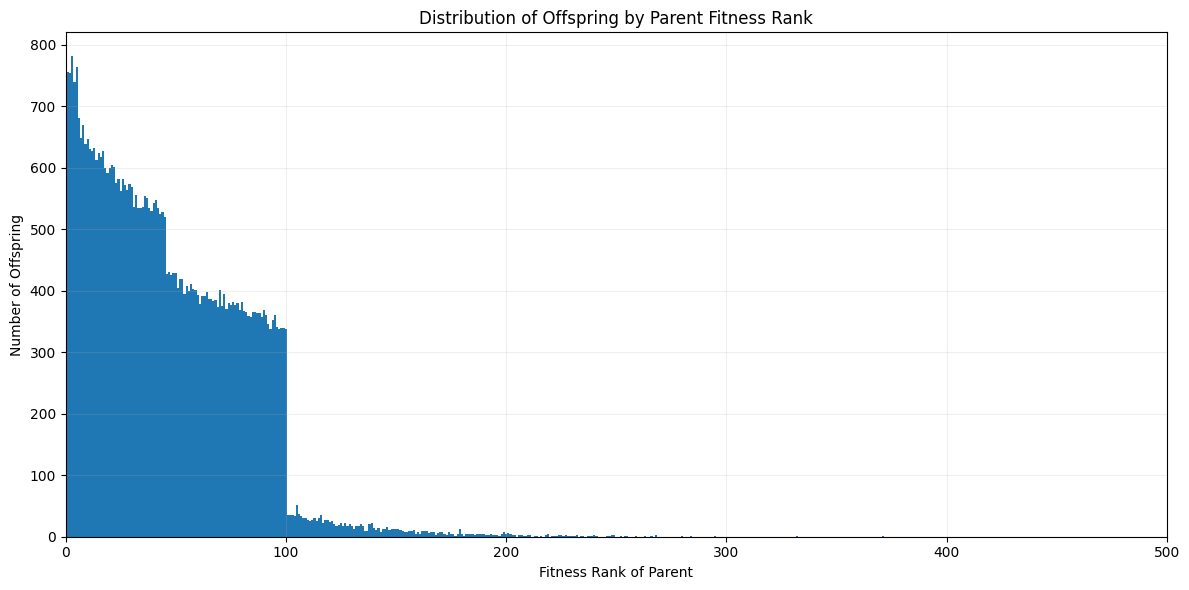

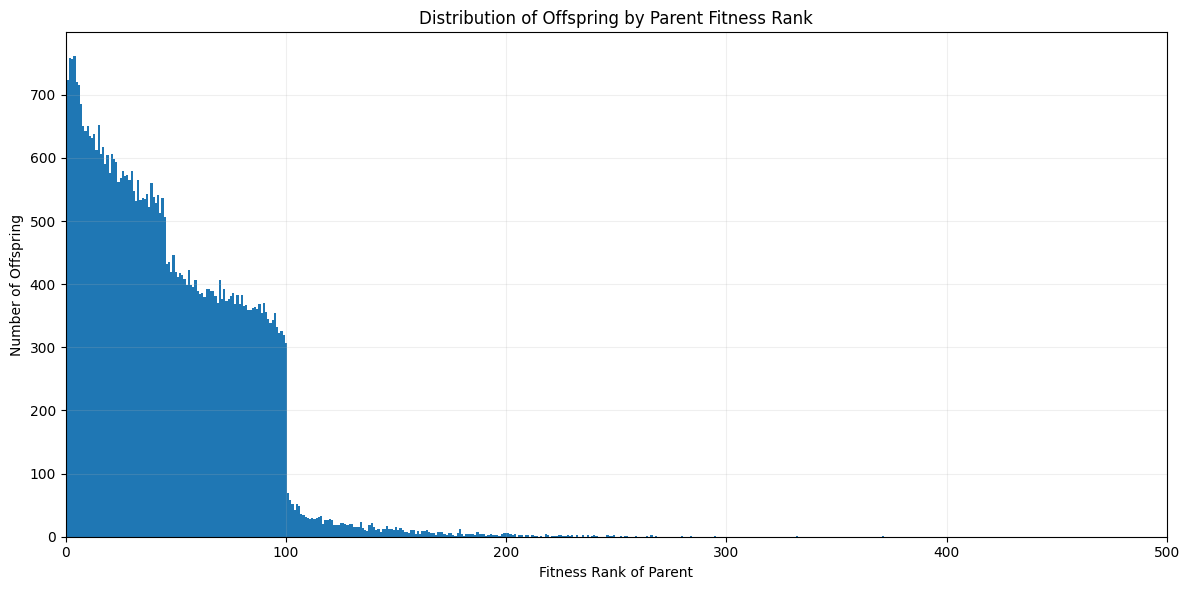

In [39]:
from copy import deepcopy
# TODO: update search method to also aggregate spawn rank
things = [
    "cutoff 10% & crossover 0%", "cutoff 10% & crossover 30%",
    "cutoff 25% & crossover 0%", "cutoff 25% & crossover 30%",
    "cutoff 50% & crossover 0%", "cutoff 50% & crossover 30%",
    "cutoff 75% & crossover 0%", "cutoff 75% & crossover 30%"
]

rs_search = {}
for d_id in things:
    data = deepcopy(cutoff_crossover_search[d_id])
    data["pop_perc_elite"] = 0.05
    rs_search[d_id] = data

for s_name, s_id in sa.search_setups(res, rs_search).items():
    print(s_name)
    rs_data = res["setups"][s_id[0]]['spawn_rank_agg']
    sa.plot_offspring_distribution(rs_data)